In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import pymc3 as pm
import skymotion
import skymotionModified
import skyfield
import corner
from scipy import optimize
from astropy.coordinates import SkyCoord
from tqdm import tqdm

##set random seed
rand_seed = np.random.randint(0,2**32-1)
## note jet angle is defined opposite to convention 
V404_jet_angle = 16 ## it is -16 in literature 
mc_iterations = 100
print("Random seed:", rand_seed)
%matplotlib inline

Random seed: 2053979094


In [8]:
def mc_normal_sampler(mu, sigma):
    s = np.random.normal(mu, sigma, 10000)
    output = float(np.random.choice(s,1)[0])
    return output

def mc_trace_sampler(trace):
    output  = float(np.random.choice(trace,1)[0])
    return output

def perturbObsBasedOnErr(obs_alpha, obs_alpha_err, obs_delta, obs_delta_err):
    
    output_alpha = []
    output_delta = []
    
    for i in range(len(obs_alpha)):
        output_alpha.append(mc_normal_sampler(obs_alpha[i], obs_alpha_err[i]))
        output_delta.append(mc_normal_sampler(obs_delta[i], obs_delta_err[i]))
        
    return np.array(output_alpha), np.array(output_delta)

In [2]:
V404_Xband = Table.read('./V404CygniXBand.txt', format='ascii',names=['RA', 'RA_err', 'DEC', 'DEC_err', 'MJD', 'MJD_err', "label"])
V404_Cband = Table.read("./V404Cygni_CBand_globalfitV3.txt", format='ascii',names=['MJD', 'MJD_err', 'RA', 'RA_err', 'DEC', 'DEC_err', 'label'])


In [3]:
V404_timeX = V404_Xband['MJD'].data
V404_alphaX = SkyCoord(V404_Xband['RA'], V404_Xband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
V404_deltaX = SkyCoord(V404_Xband['RA'], V404_Xband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
V404_alpha_errX = V404_Xband['RA_err']/3600.0*15
V404_delta_errX = V404_Xband['DEC_err']/3600.0

V404_timeC = V404_Cband['MJD'].data
V404_alphaC = SkyCoord(V404_Cband['RA'], V404_Cband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
V404_deltaC = SkyCoord(V404_Cband['RA'], V404_Cband['DEC'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
V404_alpha_errC = V404_Cband['RA_err']/3600.0*15
V404_delta_errC = V404_Cband['DEC_err']/3600.0


In [4]:
V404_timeXC = np.concatenate((V404_timeX, V404_timeC))
V404_alphaXC = np.concatenate((V404_alphaX, V404_alphaC))
V404_deltaXC = np.concatenate((V404_deltaX, V404_deltaC))
V404_alpha_errXC = np.concatenate((V404_alpha_errX, V404_alpha_errC))
V404_delta_errXC = np.concatenate((V404_delta_errX, V404_delta_errC))
V404_maskXC = np.concatenate((np.full((len(V404_timeX)), False), np.full((len(V404_timeC)), True)))
V404_x_labels, V404_c_labels = [], []
for label in V404_Xband['label']:
    V404_x_labels.append("x-" + str(label))
for label in V404_Cband['label']:
    V404_c_labels.append("c-" + str(label))

V404_labelXC = np.concatenate(( V404_x_labels, V404_c_labels))



In [5]:
with pm.Model() as uniformed_model:
    
    ra_0_guess = V404_alphaXC.mean()
    dec_0_guess = V404_deltaXC.mean()

    
    alpha_0_prior = pm.Uniform('alpha 0', lower=ra_0_guess-0.2/3600, upper=ra_0_guess+0.2/3600)
    delta_0_prior = pm.Uniform('delta 0', lower=dec_0_guess-0.2/3600, upper=dec_0_guess+0.2/3600)
    
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)
    pm_alpha_prior = pm.Uniform('pm alpha', lower=-20.0, upper=20.0)
    pm_delta_prior = pm.Uniform('pm delta', lower=-20.0, upper=20.0)
        

    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    
    #####
    
    ## apply core shift to obs
    #V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    #V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior    
    
    # Expected values for RA and Dec:
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
                                             alpha = V404_alphaXC,
                                             delta = V404_deltaXC,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    # Observed quantities:
    fitting_ra = pm.Normal('ra', mu = expected_ra, 
                           sd = V404_alpha_errXC * np.cos(V404_deltaXC*np.pi/180), 
                           observed = V404_alphaXC * np.cos(V404_deltaXC*np.pi/180))
    
    fitting_dec = pm.Normal('dec', mu = expected_dec, 
                            sd = V404_delta_errXC, 
                            observed = V404_deltaXC)
    step_method = pm.NUTS()
    V404_trace_2D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:58: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 33 seconds.


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>]], dtype=object)

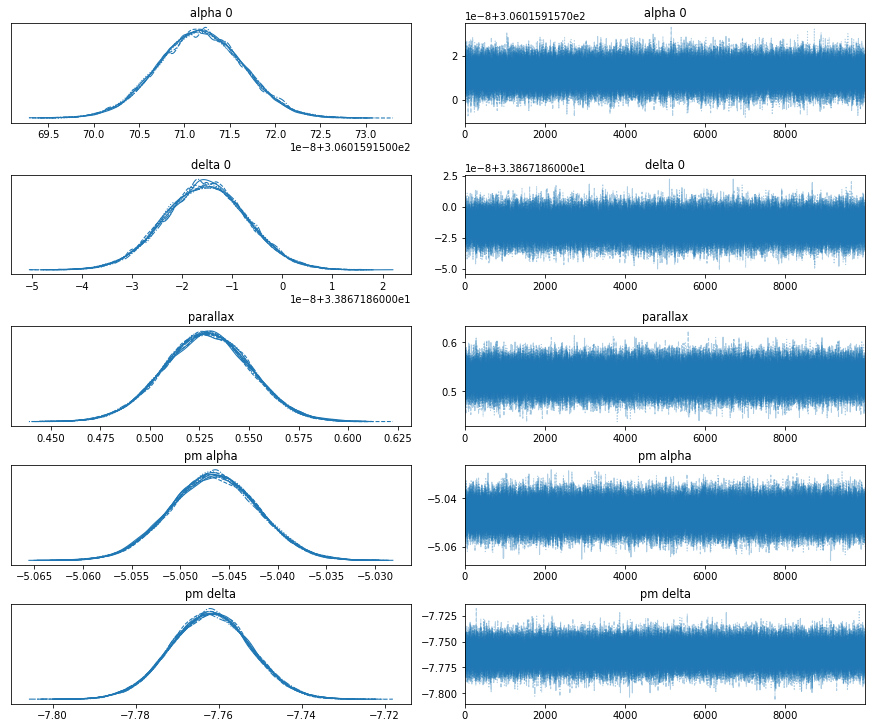

In [6]:
pm.traceplot(V404_trace_2D)

100%|██████████| 100/100 [00:01<00:00, 50.02it/s]


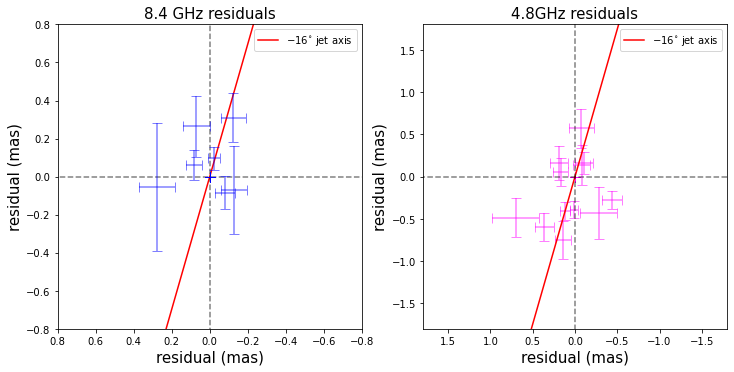

In [41]:
hfont = {'fontname':'Helvetica', 'size':15}

V404_c_band_mask = np.invert(np.copy(V404_maskXC))
V404_ra_residual_trace = []
V404_dec_residual_trace = []
V404_ra_parallax_signal_trace = []
V404_dec_parallax_signal_trace = []
V404_perp_trace = []
V404_para_trace = []

for i in tqdm(range(mc_iterations)):
    
    ## perturb observation
    V404_alpha, V404_delta = perturbObsBasedOnErr(V404_alphaXC, V404_alpha_errXC,\
                                                V404_deltaXC, V404_delta_errXC)
    
    V404_time = np.copy(V404_timeXC)
    
    ## perturb proper motion and parallax
    pm_alpha_deg = mc_trace_sampler(V404_trace_2D['pm alpha']) / 3.6e6 / 365.25    
    pm_delta_deg = mc_trace_sampler(V404_trace_2D['pm delta']) / 3.6e6 / 365.25    
    parallax_deg = mc_trace_sampler(V404_trace_2D['parallax']) / 3.6e6
    alpha_0 = mc_trace_sampler(V404_trace_2D['alpha 0'])
    delta_0 = mc_trace_sampler(V404_trace_2D['delta 0'])
    
    ## compute proper motion and residuals
    frac_alpha, frac_delta = skymotion.frac_parallax(V404_time, V404_alpha, V404_delta)
    ref_t = skymotion.t_0(V404_time)
    fit_ra_proper = alpha_0 * np.cos(np.radians(V404_delta)) + (pm_alpha_deg * (V404_time - ref_t))
    fit_dec_proper = delta_0 + (pm_delta_deg * (V404_time - ref_t))
    fit_ra = fit_ra_proper + frac_alpha * parallax_deg
    fit_dec = fit_dec_proper + frac_delta * parallax_deg
    
    V404_ra_parallax_signal_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra_proper)
    V404_dec_parallax_signal_trace.append(V404_delta - fit_dec_proper)
    V404_ra_residual_trace.append(V404_alpha* np.cos(np.radians(V404_delta)) - fit_ra)
    V404_dec_residual_trace.append(V404_delta - fit_dec)
    
    
    
    

time_array = np.linspace(np.min(V404_timeXC)-50, np.max(V404_timeXC)+50, 200)

frac_alpha, frac_delta = skymotion.frac_parallax(time_array, np.mean(V404_trace_2D['alpha 0']), \
                                                 np.mean(V404_trace_2D['delta 0']) )

parallax_deg = np.mean(V404_trace_2D['parallax'])
    



fig = plt.figure(figsize=(12,6))



ax1 = fig.add_subplot(121)
x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(16 + 90))
plt.plot(x_array, y_array, color="red", label=r'$-16^{\circ}$ jet axis')
plt.title("8.4 GHz residuals",**hfont)
plt.xlabel("residual (mas)",**hfont)
plt.ylabel("residual (mas)",**hfont)
plt.xlim(0.8, -0.8)
plt.ylim(-0.8, 0.8)
plt.legend()
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
             xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_c_band_mask, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_c_band_mask,\
             fmt=' ', capsize=5,color="blue", alpha=0.5)



ax2 = fig.add_subplot(122)
plt.errorbar(np.median(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, np.median(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
             xerr=np.std(V404_ra_residual_trace, axis=0)*3.6e6*V404_maskXC, yerr=np.std(V404_dec_residual_trace, axis=0)*3.6e6*V404_maskXC,\
             fmt=' ', capsize=5,color="magenta", alpha=0.5)


x_array = np.linspace(-1.5, 1.5, 10)
y_array = x_array*np.tan(np.radians(16 + 90))
plt.plot(x_array, y_array, color="red", label=r'$-16^{\circ}$ jet axis')
plt.title("4.8GHz residuals",**hfont)
plt.xlabel("residual (mas)",**hfont)
plt.ylabel("residual (mas)",**hfont)
plt.xlim(1.8, -1.8)
plt.ylim(-1.8, 1.8)
plt.legend()
plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)

ax1.set_aspect('equal')
ax2.set_aspect('equal')


plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
#plt.savefig('V4042Dresiduals.png')

### only Xband 1D fit